# UnhapPy Earth - Analyse et Modélisation

Étude de cas : Analyse du réchauffement climatique. Analyse approfondie des données en rapport avec nos questions de recherche, et modélisation.



## Contexte et objectifs
Notre objectif est de proposer une analyse du réchauffement climatique, en répondant aux problématiques suivantes :
- Pouvons-nous confirmer grâce aux données le phénomène de changement climatique ? Le réchauffement, est-il réellement observable ?
- Quand le phénomène apparaît-il ? De manière soudaine ou graduelle ? Au même moment sur l’ensemble du globe ?
- Son évolution, est-elle uniforme à travers le monde ou certaines zones sont-elles plus impactées que d’autres ?
- Le CO2 serait, parmi l’ensemble des gaz à effet de serre émis, la principale cause du réchauffement de la planète. Existe-t-il une forte corrélation entre les émissions de CO2 et l’évolution des températures ?
- Des événements historiques ont-ils eu un impact sur l'évolution de la température ?
- Quelles sont nos prédictions de température sur les prochaines années ?
- A quelles conclusions parviennent les scientifiques - climatologues ? 




# Initialisation du NoteBook

Dans cette section nous importons les packages nécessaires et créons les fonctions dont nous nous servirons au cours de l'analyse exploratoire.


## Connexion au Google Drive & Import des packages

In [2]:
# Montage du Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import des packages

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm

## Fonctions de visualisation

Définition de fonctions de plotting, par mois ou par an, pour une ou plusieurs régions. 

### Fonction `plot_month`
Fonction permettant d'afficher un graphique montrant l'évolution des températures par mois, pour un DF donnée, ainsi que leur moyenne glissante sur 12 mois.

In [4]:
# Définition de la fonction plot_month :

def plot_month(df, title) :
  """
  Display both a plot and a scatter plot from a DF, with x = date (by month) and y = absolute temperature.
  Add a cmap to colorize the scatter based on y value.
  Plot 12-months moving average temperature.
  """
  # Set the figure size and grid.
  plt.figure(figsize=(24,10))
  plt.grid(color='grey', alpha=0.2)

  # Display line for monthly measures
  plt.plot(df['date'], df['abs'], c='lightgrey', zorder=1)
  # Display points (circles) for monthly measures
  plt.scatter(df['date'], df['abs'], c=df['abs'], cmap='jet', s=15, zorder=2,
              label='Moyennes mensuelles')
  # Display 12-months moving average as a straight, larger line.
  plt.plot(df['date'], df['mov_average'], color='k', linewidth=2, label='Moyenne glissante sur 12 mois')

  # Add the cmap.
  plt.colorbar()
  plt.clim(df['abs'].min(), df['abs'].max())

  # Labels, legend, title.
  plt.xlabel('Date (par mois)')
  plt.ylabel('Température absolue en °C')
  plt.legend()
  plt.title(title)
  plt.show()

### Fonction `plot_year`
Fonction permettant d'afficher un graphique montrant l'évolution des températures par an, pour un DF donnée, avec ou sans la marge d'incertitude associée.

In [5]:
# Définition de la fonction plot_year :

def plot_year(df, title, show_uncert=False) :
  """
  Display both a plot and a scatter plot from a DF, with x = date (by year) and y = absolute temperature.
  The 'show_uncert' parameter allows, if True, to display the uncertainty margin.
  Add a cmap to colorize the scatter plot based on y value, when uncertainty is not plotted.
  """
  # Compute the average of abs and uncert by year.
  temp_year = df[['year', 'abs', 'uncert']].groupby('year').mean().reset_index()
  # Set the figure size and grid.
  plt.figure(figsize=(24,10))
  plt.grid(color='grey', alpha=0.2)

  # Display absolute temperatures.
  plt.plot(temp_year['year'], temp_year['abs'], c='grey', zorder=1)

  # If required, display points and fill the area of uncertainty measures.  
  if show_uncert==True :
    plt.scatter(temp_year['year'], temp_year['abs'],
              edgecolor='none', zorder=2, label='Moyennes annuelles')
    plt.fill_between(temp_year['year'], 
                 temp_year['abs'] - temp_year['uncert'], 
                 temp_year['abs'] + temp_year['uncert'],
                 color='#D3D3D3', zorder=0, label='Incertitude')
  # Otherwise display absolute temps with a colormap.
  else :
    plt.scatter(temp_year['year'], temp_year['abs'], c=temp_year['abs'],
            cmap='jet', vmin=-40.5, vmax=40, edgecolor='none', zorder=2,
            label='Moyennes annuelles')
    plt.colorbar()
    plt.clim(temp_year['abs'].min(), temp_year['abs'].max())

  # Labels, legend, title.
  plt.xlabel('Date (par annnée)')
  plt.ylabel('Température absolue en °C')
  plt.title(title)
  plt.legend()
  
  plt.show()
  
  # Add some statistics about the graphic.
  print("Ecart maximal de température moyenne annuelle :", round(temp_year['abs'].max() - temp_year['abs'].min(), 3))
  print("Incertitude maximale :", round(temp_year['uncert'].max()*2, 3))
  print("Incertitude minimale :", round(temp_year['uncert'].min()*2, 3))

### Fonction `mult_plot_year`
Fonction permettant d'afficher côte-à-côte deux graphiques montrant l'évolution des températures par mois, pour deux DF (deux régions) donnés.

In [6]:
def mult_plot_year(df_list, label_list, color_list, title) :
  """
  Display multiple plots (with uncertainty margins if available) from a list of DFs,
  with x = date (by year) and y = absolute temperature.
  """
  
  # Set figure size and grid
  plt.figure(figsize=(24,10))
  plt.grid(color='grey', alpha=0.2)
  
  for df, label, color in zip(df_list, label_list, color_list) :
  
    # Compute average absolute temperatures by year
    temp_year = df.groupby('year').mean().reset_index()

    # Display absolute temperatures
    plt.plot(temp_year['year'], temp_year.iloc[:,1], c=color, label=label)
    
    # Display uncertainty if available :
    if len(df.columns) > 2 :
      # Display uncertainty margin
      plt.fill_between(temp_year['year'], 
                       temp_year.iloc[:,1] - temp_year.iloc[:,2], 
                       temp_year.iloc[:,1] + temp_year.iloc[:,2],
                       color=color, alpha = 0.2, label=('Incertitude '+ label))
 
  # Labels, legend, title
  plt.xlabel('Date (par année)')
  plt.ylabel('Température absolue en °C')
  plt.title(title)
  plt.legend()

  plt.show()

### Lecture des jeux de données


In [7]:
global_land = pd.read_csv('/content/drive/MyDrive/data/unhappy_earth/temperatures_globales.csv')
hems = pd.read_csv('/content/drive/MyDrive/data/unhappy_earth/temperatures_hemispheres.csv')
temps_countries =pd.read_csv('/content/drive/MyDrive/data/unhappy_earth/temperatures_countries.csv')
co2_global = pd.read_csv('/content/drive/MyDrive/data/unhappy_earth/co2_global.csv')
co2_countries = pd.read_csv('/content/drive/MyDrive/data/unhappy_earth/co2_countries.csv')

global_land['date'] = pd.to_datetime(global_land['date'])
hems['date'] = pd.to_datetime(hems['date'])
temps_countries['date'] = pd.to_datetime(temps_countries['date'])

# Analyse


## Qu'est-ce que le réchauffement climatique?


Le réchauffement climatique est un phénomène de changement climatique caractérisé par une augmentation générale des températures moyennes à la surface de la Terre, qui modifie l'équilibre climatique et les écosystèmes.

## Pouvons-nous confirmer le phénomène de changement climatique ? 

Nous allons commencer notre analyse par la confirmation de ce phénomène. A cet effet, nous présentons sur le graphique l'évolution des températures mensuelles globales, de 1750 à 2021. Egalement, nous allons visualiser la moyenne annuelle glissante sur l'ensembre des données, rendant plus visible la tendance générale. 

In [8]:
global_land.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3265 non-null   datetime64[ns]
 1   year         3265 non-null   int64         
 2   month        3265 non-null   int64         
 3   ano          3265 non-null   float64       
 4   uncert       3265 non-null   float64       
 5   abs          3265 non-null   float64       
 6   mov_average  3254 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 178.7 KB


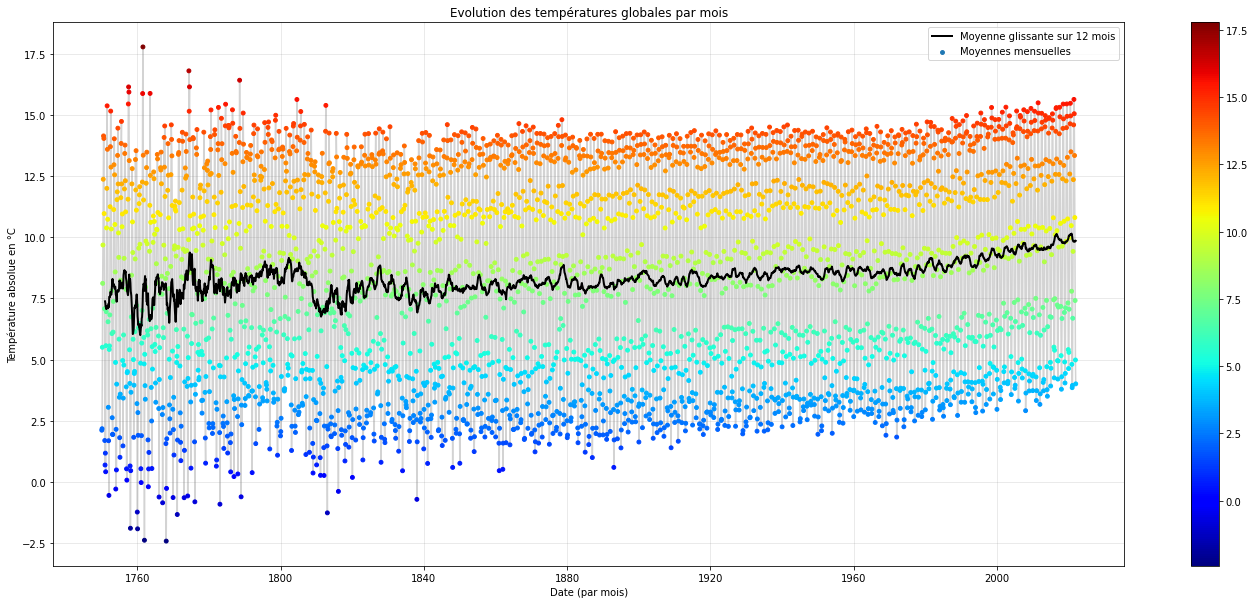

In [9]:
plot_month(global_land, 'Evolution des températures globales par mois')

Nous pouvons observer des variations saisonnales correspondant à chaque année, matérialisées par les bandes de couleurs pour chaque variation annuelle de température. Nous pouvons d'ores et déjà observer visuellement une tendance croissante en suivant les points d'une même couleur (i.e. les valeurs saisonnales augmentent globalement). 

Approximativement, jusqu'à la moitié du graphique (année 1880) la dispersion des bandes de couleurs est beaucoup plus importante, qui s'accompagne d'une plus grande incertitude. Les données collectées à cette époque sont moins fiables, à cause des capteurs utilisés et d'un nombre de stations météorologiques restreint. Cette incertitude est clairement representée dans le graphique suivant. 

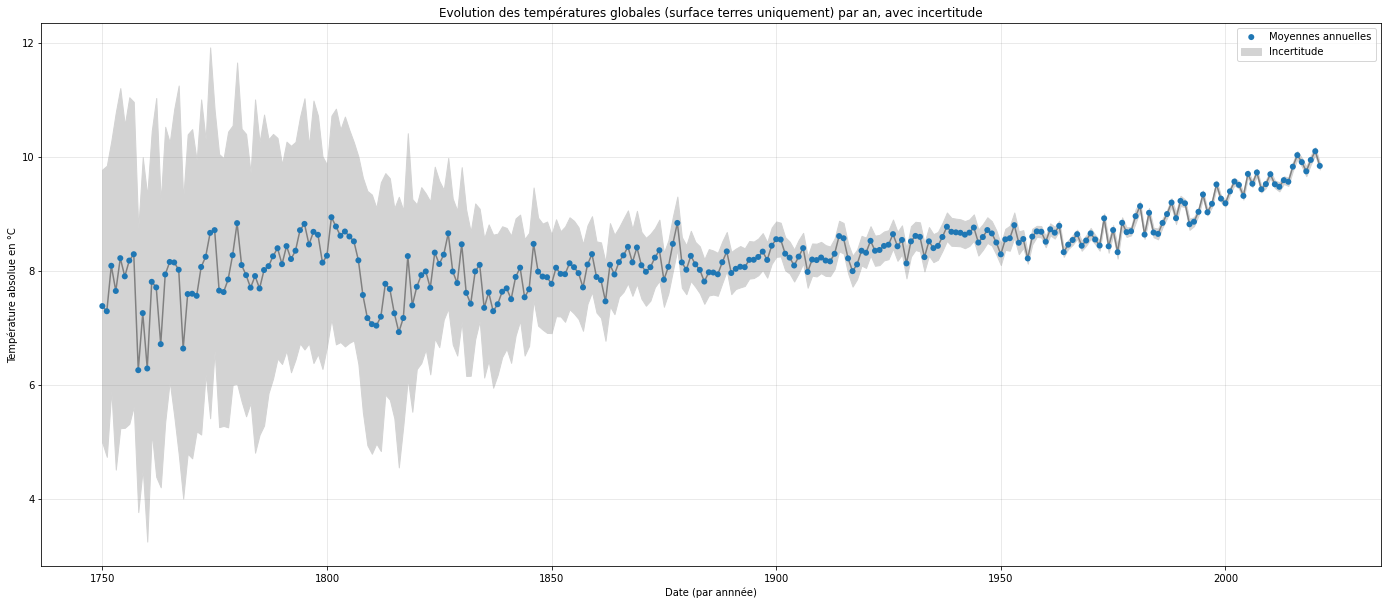

Ecart maximal de température moyenne annuelle : 3.844
Incertitude maximale : 6.65
Incertitude minimale : 0.11


In [10]:
plot_year(global_land[:-1], 
          'Evolution des températures globales (surface terres uniquement) par an, avec incertitude',
          show_uncert=True)

La tendance est encore plus visible sur la moyenne annuelle glissante : si jusqu'à 1880 la moyenne oscillait autour de 8 °C, sur les dernières décennies elle remonte autour de 10 °C. Nous pouvons identifier une augmentation approximative de 2 °C en un peu plus d'un siècle. 

Bien que cette valeur puisse paraître relativement petite (au vu, par exemple, des oscillations de la température entre jour et nuit, ou même été et hiver), les conséquences sur l'équilibre global sont énormes.

Afin de mieux se rendre compte de cette tendance, et pour lisser un peu les variations annuelles que l'on peut observer, nous calculons une moyenne glissante sur 10 ans. 


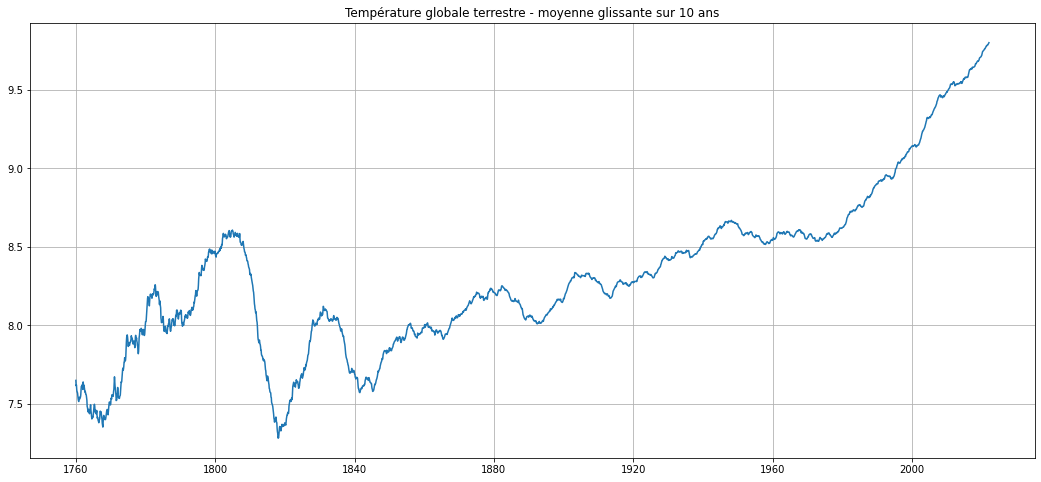

'Diff entre 1850 (7.85715) et 2022 (9.800266666666667) est de 1.9431166666666675.'

'Diff entre 1900 (8.170558333333334) et 2022 (9.800266666666667) est de 1.6297083333333333.'

In [11]:
# Moyenne glissante sur 10 ans.
global_land_mov_average_10y = []
for i in np.arange(120, global_land.shape[0]):
  i_prec = i - 120
  global_land_mov_average_10y.append(global_land.iloc[i_prec:i, 5].mean())
global_land_mov_average_10y = pd.DataFrame({'temp': global_land_mov_average_10y}, index=global_land['date'][120:])

plt.figure(figsize=(18,8))
plt.plot(global_land_mov_average_10y['temp'])
plt.title('Température globale terrestre - moyenne glissante sur 10 ans')
plt.grid()
plt.show()

temp_1850 = global_land_mov_average_10y.loc['1850-01-15', 'temp']
temp_1900 = global_land_mov_average_10y.loc['1900-01-15', 'temp']
temp_2022 = global_land_mov_average_10y.loc['2022-01-15', 'temp']
display(f"Diff entre 1850 ({temp_1850}) et 2022 ({temp_2022}) est de {temp_2022-temp_1850}.")
display(f"Diff entre 1900 ({temp_1900}) et 2022 ({temp_2022}) est de {temp_2022-temp_1900}.")

Les premières années sont assez chaotiques, et cela est très bien corrélé avec l'incertitude que nous avons déjà observée. À partir de ces observations, nous sélectionnons une période de temps plus stable, par exemple à partir des années 1850, et calculons les différences avec les 10 dernières années :
* La différence de température moyenne sur 10 ans entre 1850 et 2022 est de 1.943°C.
* La différence de température moyenne sur 10 ans entre 1900 et 2022 est de 1.63°C.

Donc, **oui, le réchauffement climatique existe bel et bien** !

## Le réchauffement commence-t-il au même moment sur l’ensemble du globe ?

Après l'observation des deux graphiques précédents, il n'est pas possible d'établir précisément le début du réchauffement climatique. Il s'agit même d'un sujet de désaccord entre experts, qui depuis des années ne parviennent pas à une réponse unique. Certaines recherches le corrèlent avec la révolution industrielle occidentale, telles que les travaux de [Abram et. al.](http://rdcu.be/jVFv) ou ceux du [groupe PAGES](https://www.ipsl.fr/Actualites/Actualites-scientifiques/Le-rechauffement-climatique-anthropique-aurait-debute-au-tout-debut-de-la-revolution-industrielle). D'autres études indiquent un début plus précoce. 

Le réchauffement climatique est très graduel, et subit des variations cycliques qui rendent difficile une datation précise.

Néanmoins, en étudiant à nouveau le graphique, nous pouvons observer une tendance beaucoup plus explicite, forte et continue à partir des années 1975. De plus, dans les décennies précédent les années 1970, les températures moyennes mondiales semblent être assez stables, ce qui a suscité de vives controverses dans le domaine de la climatologie. En fait, il existe même [quelques études publiées entre 1965 et 1979](https://www.lemonde.fr/cop21/article/2015/10/22/hoax-climatique-3-dans-les-annees-1970-les-scientifiques-prevoyaient-un-refroidissement_4794858_4527432.html), qui prévoyaient une baisse des températures. En 1975, le New York Times titre aussi bien :

« Des scientifiques s’interrogent sur les raisons du changement climatique : un refroidissement majeur pourrait être en vue », que :

« Une tendance au réchauffement est observée : deux études contredisent l’idée d’une prochaine période froide ».

Dès la fin de cette décennie, le quotidien américain tranche et prend position dans un éditorial, le 12 juillet 1979, relayant sans équivoque l’inquiétude des chercheurs devant l’imminence du réchauffement.

Pour déterminer si le réchauffement se produit au même moment sur l'ensemble du globe ou pas, nous allons analyser l'évolution des températures sur les deux hémisphères.

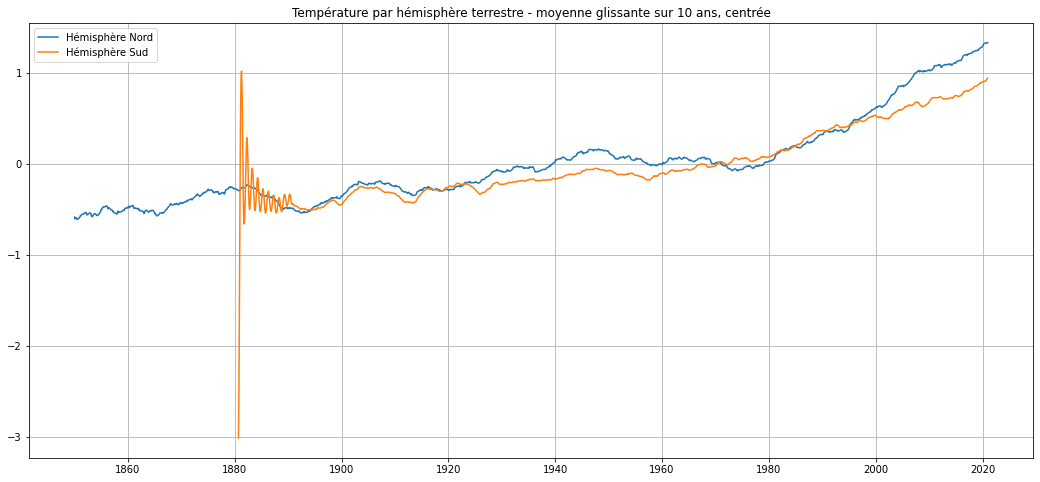

In [12]:
# Moyenne glissante sur 10 ans.
hems_mov_average_10y_na = []
hems_mov_average_10y_nu = []
hems_mov_average_10y_sa = []
hems_mov_average_10y_su = []
for i in np.arange(120, hems.shape[0]):
  i_prec = i - 120
  hems_mov_average_10y_na.append(hems.iloc[i_prec:i, 4].mean())
  hems_mov_average_10y_nu.append(hems.iloc[i_prec:i, 5].mean())
  hems_mov_average_10y_sa.append(hems.iloc[i_prec:i, 8].mean())
  hems_mov_average_10y_su.append(hems.iloc[i_prec:i, 9].mean())

hems_mov_average_10y = pd.DataFrame({'north_abs': hems_mov_average_10y_na, 
                                     'north_uncert': hems_mov_average_10y_nu, 
                                     'south_abs': hems_mov_average_10y_sa, 
                                     'south_uncert': hems_mov_average_10y_su
                                     }, index=hems['date'][120:])

years = hems_mov_average_10y.reset_index()['date'].apply(lambda x: int(str(x).split('-')[0]))

hems_mov_average_10y['north_abs_10y_centered'] = hems_mov_average_10y['north_abs'] - hems_mov_average_10y['north_abs'].mean()
hems_mov_average_10y['north_uncert_10y_centered'] = hems_mov_average_10y['north_uncert'] - hems_mov_average_10y['north_uncert'].mean()
hems_mov_average_10y['south_abs_10y_centered'] = hems_mov_average_10y['south_abs'] - hems_mov_average_10y['south_abs'].mean()
hems_mov_average_10y['south_uncert_10y_centered'] = hems_mov_average_10y['south_uncert'] - hems_mov_average_10y['south_uncert'].mean()

plt.figure(figsize=(18,8))
plt.plot(hems_mov_average_10y['north_abs_10y_centered'], label='Hémisphère Nord')
plt.plot(hems_mov_average_10y['south_abs_10y_centered'], label='Hémisphère Sud')
plt.title('Température par hémisphère terrestre - moyenne glissante sur 10 ans, centrée')
plt.legend()
plt.grid()

De la même manière que pour les températures globales, dans ce graphique par hémisphère nous ne pouvons identifier avec précision un point de départ du réchauffement climatique. Les deux hémisphères montrent une tendance croissante, mais il est intéressant de remarquer que leur comportement est différent entre l'un et l'autre. La hausse de température dans l'hémisphère Sud est graduelle et constante, tandis que dans l'hémisphère Nord d'importantes variations apparaissent. 

Sur cette dernière période (1970 - 2021), dans l'hémisphère Sud la température moyenne passe de 16,9 °C à 18 °C, soit une augmentation de 1,1 °C, tandis que dans l'hémisphère Nord la température passe de 10 °C à 11,8 °C, soit 1,8 °C d'augmentation sur la même periode.

A cause de ces variations, il est difficile d'établir si le réchauffement a débuté plus tôt dans un hémisphère que dans l'autre, mais **nous pouvons observer globalement un réchauffement plus rapide de l'hémisphère Nord**. 

Afin de valider cette interprétation, nous allons étudier plus en détail l'évolution des températures dans les différents pays et continents.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


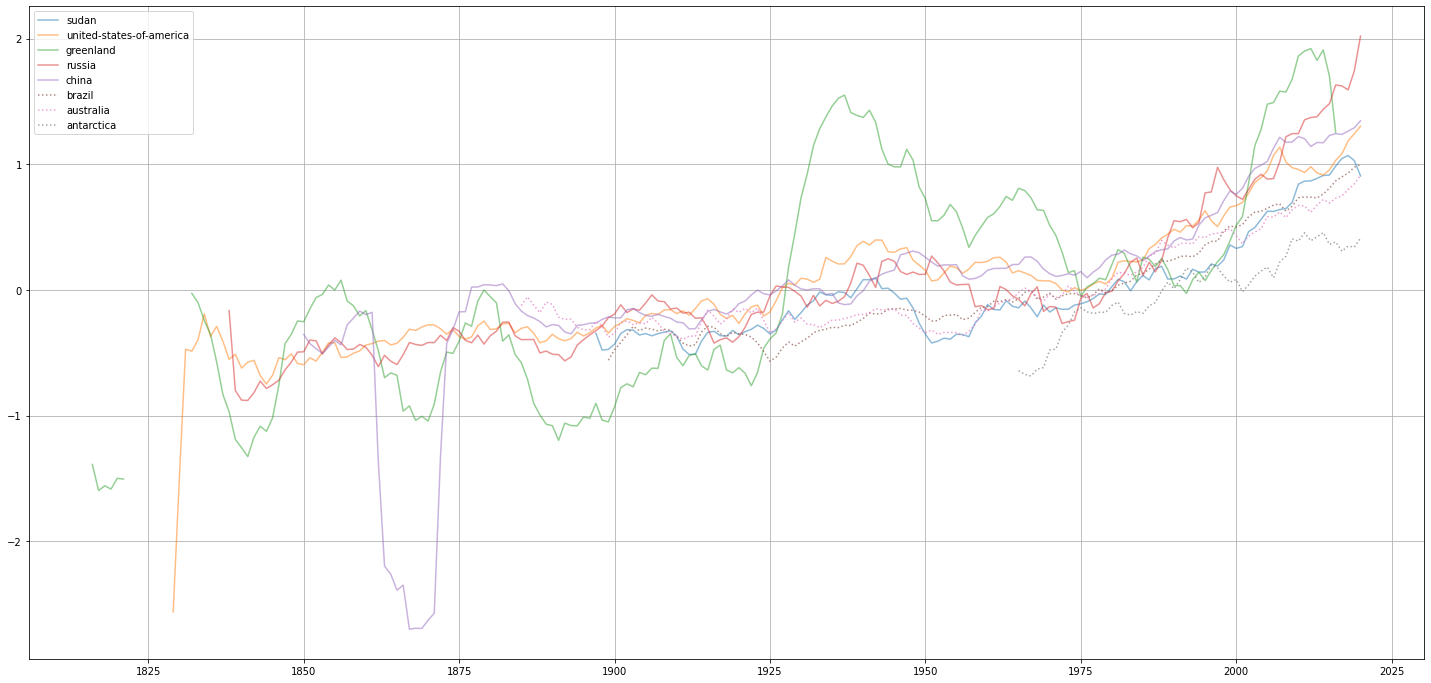

In [13]:
# Compute yearly average
temps_countries_year = pd.DataFrame()
#display(temps_countries)
for c in temps_countries.iloc[:,2:]:
  temps_countries_year[c] = temps_countries.groupby(by='year').agg({c: 'mean'})
temps_countries_year = temps_countries_year.reset_index()

#display(temps_countries_year)
for c in temps_countries_year.iloc[:,1:]:
  temps_countries_year[c] = temps_countries_year[c].rolling(10).mean()

temps_countries_year_centered = temps_countries_year.copy()
for c in temps_countries_year.columns:
  temps_countries_year_centered[c] = temps_countries_year[c] - temps_countries_year[c].mean()

selected_countries_n = ['sudan', 'united-states-of-america', 
                      'greenland', 
                      'russia', 
                      'china']
selected_countries_s = ['brazil',
                      'australia', 'antarctica']

plt.figure(figsize=(25,12))
#plt.ylim(-.5, 2)
for c in selected_countries_n:
  plt.plot(temps_countries_year['year'], temps_countries_year_centered[c], alpha=.5, label=c, linestyle='-')
for c in selected_countries_s:
  plt.plot(temps_countries_year['year'], temps_countries_year_centered[c], alpha=.7, label=c, linestyle=':')
plt.grid()
plt.legend()
plt.show()

Nous retrouvons sur ce graphique les éléments observés précédemment : le réchauffement est plus rapide dans l'hémisphère nord (courbes en trait plein) que dans l'hémisphère sud (courbes en trait pointillé). Sur l'ensemble des pays sélectionnés, on peut même observer que **plus les pays sont situés au Nord, plus la différence de température est visible**.

## Le réchauffement est-il uniformément distribué sur le globe ?

Nous souhaitons visualiser l'évolution des températures à l'échelle du globe, par pays. Nous devons tout d'abord installer les packages nécessaires, en l'occurrence `geopandas`.

In [14]:
!pip install geopandas geoplot mapclassify pycountry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 36.6 MB/s 
     |████████████████████████████████| 10.1 MB 45.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 16.7 MB 51.8 MB/s 
     |████████████████████████████████| 6.3 MB 56.3 MB/s 
     |████████████████████████████████| 10.8 MB 60.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 58.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 57.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 81.5 MB/s 
  Installing build dependencies ... do

In [15]:
import geopandas as gpd

# get the geometry (and some more info) about countries.
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# Fix some bugs/missing codes in pycountry
world['CODE'].loc[world['name'] == 'France'] = 'FRA'
world['CODE'].loc[world['name'] == 'Norway'] = 'NOR'

# Build our dataframe with proper formatting.
df_geo = temps_countries_year.set_index('year').T.reset_index().rename(columns={'index': 'CODE'})

# pycountry lookup doesn't recognise some country name, help it a bit.
df_geo['CODE'] = df_geo['CODE'].replace({
    'russia': 'Russian Federation',
    'united-states-of-america': 'United States',
    'united-kingdom': 'United Kingdom',
    'syria': 'Syrian Arab Republic',
    'central-african-republic': 'Central African Republic',
    'south-africa': 'South Africa',
    'federated-states-of-micronesia': 'Micronesia, Federated States of',
    'iran': 'Iran, Islamic Republic of',
    'islas-baleares': 'islas-baleares',
    'laos': "Lao People's Democratic Republic",
    'timor': 'Timor-Leste',
    'south-korea': "Korea, Republic of",
    'north-korea': "Korea, Democratic People's Republic of",
    'cabo-verde': 'Cabo Verde',
    'costa-rica': 'Costa Rica',
    'saudi-arabia': 'Saudi Arabia',
    'bosnia-and-herzegovina': 'Bosnia and Herzegovina',
    'reunion': 'Réunion',
    'new-zealand': 'New Zealand',
    })

# convert countries to 3-letter code
import pycountry
remove_rows = []
for i, v in enumerate(df_geo['CODE']):
    try:
      c = pycountry.countries.lookup(v)
      df_geo.iloc[i, 0] = c.alpha_3
    except Exception:
      #display(f"Could not find country {v}.")
      remove_rows.append(i)
df_geo = df_geo.drop(index=remove_rows, axis=0)

# then merge with our data 
merge = pd.merge(world, df_geo, on='CODE', how='outer')
display(merge)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,pop_est,continent,name,CODE,gdp_md_est,geometry,1743,1744,1745,1750,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,920938.0,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN,NaN,...,25.810525,25.785625,25.823950,25.841075,25.834167,25.873508,25.868567,25.882592,25.955450,25.975308
1,53950935.0,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN,NaN,NaN,...,23.059658,23.072425,23.053208,23.042250,22.992700,23.069468,NaN,NaN,NaN,NaN
2,603253.0,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35623680.0,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",NaN,NaN,NaN,NaN,...,-3.665625,-3.536808,-3.564425,-3.495708,-3.522742,-3.553983,-3.473933,-3.480283,-3.445417,-3.628925
4,326625791.0,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",NaN,NaN,NaN,NaN,...,9.640942,9.687017,9.637742,9.620200,9.661800,9.737475,9.789867,9.891417,9.949800,10.009333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,NaN,NaN,NaN,REU,NaN,None,NaN,NaN,NaN,NaN,...,24.085142,24.077425,24.055017,24.088075,24.132350,24.310897,NaN,NaN,NaN,NaN
202,NaN,NaN,NaN,WSM,NaN,None,NaN,NaN,NaN,NaN,...,26.910275,26.878267,26.905700,26.914450,26.910725,26.988333,26.993742,27.027925,27.079008,27.078275
203,NaN,NaN,NaN,SYC,NaN,None,NaN,NaN,NaN,NaN,...,27.538675,27.564917,27.569108,27.594908,27.648817,27.686392,27.698892,27.719083,27.757583,27.800542
204,NaN,NaN,NaN,SGP,NaN,None,NaN,NaN,NaN,NaN,...,27.385858,27.370975,27.385225,27.402100,27.435000,27.505550,27.550933,27.594067,27.654317,27.673783


### Températures mondiales

Afin de mieux appréhender les différences de température au niveau mondial, nous visualisons les températures dans l'ensemble des pays du monde (pour lesquels nous avons des données) au début du siècle dernier, en 1900, et aujourd'hui (données accessibles jusqu'en 2020). Nous utilisons la même échelle de couleur pour permettre une bonne comparaison.

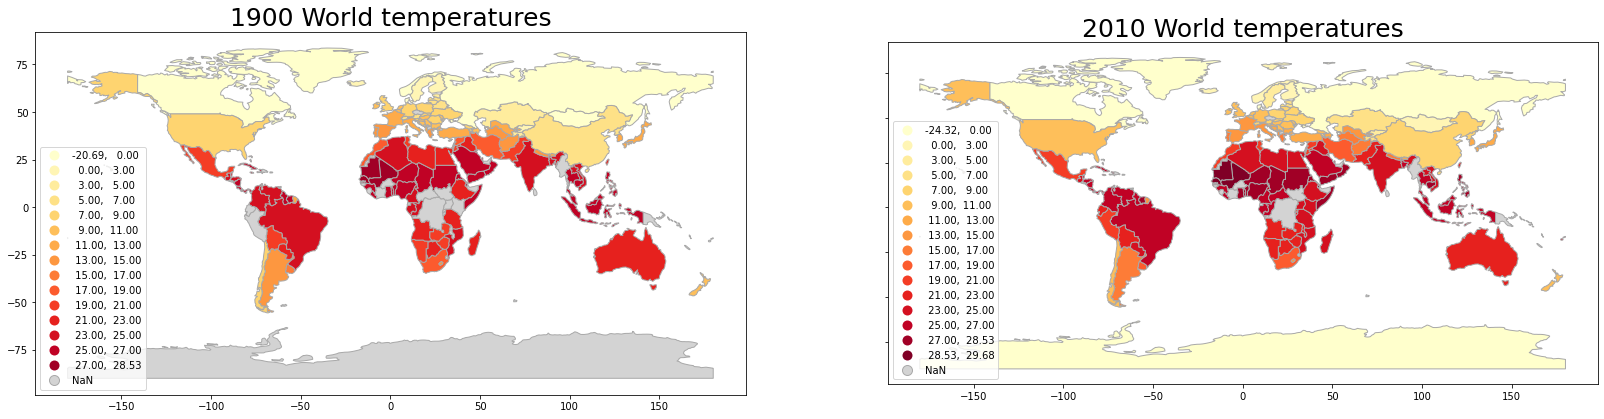

In [16]:
from matplotlib.colors import Normalize
from mapclassify import UserDefined

bins = UserDefined(merge[1960], bins=[0,3,5,7,9,11,13,15,17,19,21,23,25,27]).bins

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(28, 24))
# plot world map 
merge.plot(ax=ax1, column=1900, 
           legend=True, cmap='YlOrRd',
           missing_kwds= dict(color="lightgrey",), 
           edgecolor='darkgrey', linewidth=1, legend_kwds={'loc': 'lower left'},
           scheme='userdefined', classification_kwds={'bins':bins}, norm=Normalize(0, len(bins)), vmin=-20, vmax=23)
ax1.set_title('1900 World temperatures', fontsize=25)

# plot world map 
merge.plot(ax=ax2, column=2010, 
           legend=True, cmap='YlOrRd',
           missing_kwds= dict(color="lightgrey",), 
           edgecolor='darkgrey', linewidth=1, legend_kwds={'loc': 'lower left'},
           scheme='userdefined', classification_kwds={'bins':bins}, norm=Normalize(0, len(bins)), vmin=0, vmax=23)
ax2.set_title('2010 World temperatures', fontsize=25)
plt.show()

L'augmentation est visible ; beaucoup de pays ont une couleur plus prononcée en 2010 -- la quasi-totalité des pays a pris au moins une teinte de couleur plus sombre, et l'algorithme a même dû ajouter une catégorie de température (> 28.58°C).

### Différence sur un siècle

Nous voulons identifier l'augmentation de température sur l'ensemble des pays, en prenant comme référence les températures observées au début du siècle précédent (1900) et en les comparant aux températures observées ces dernières années (2010).


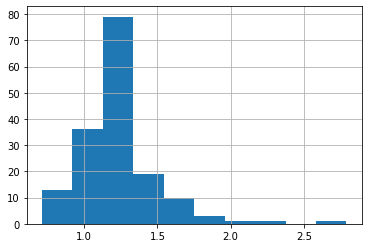

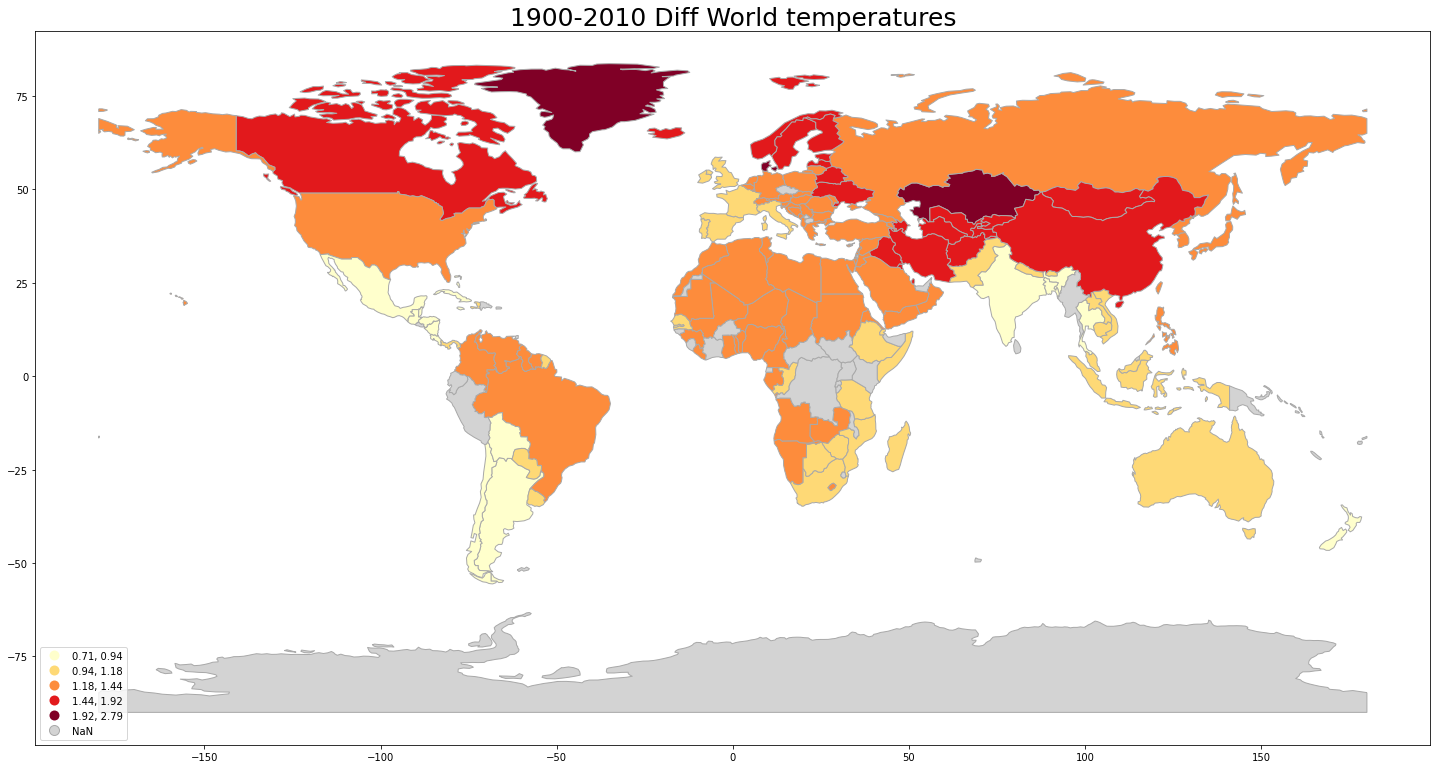

In [17]:
merge['diff'] = merge[2010] - merge[1900]
merge['diff'].hist()

# plot world map 
merge.plot(column='diff', 
           legend=True, cmap='YlOrRd',
           missing_kwds= dict(color="lightgrey",), 
           figsize=(25, 20),
           edgecolor='darkgrey', linewidth=1, legend_kwds={'loc': 'lower left'},
           scheme='NaturalBreaks')
plt.title('1900-2010 Diff World temperatures', fontsize=25)
plt.show()

On retrouve les observations précédentes : l'augmentation de température est en moyenne plus importante dans l'hémisphère nord, et croît globalement en remontant vers le Nord. Cela n'est pas uniforme, cependant, et d'autres paramètres doivent entrer en compte. Nous savons que la climatologie est une science complexe, et des paramètres locaux (type environnement local, ou régulations de certains pays) autant que systémique par les effets globaux du climat, tels que les modifications des courants océaniques et atmosphériques.

## L'évolution des températures est elle corrélée aux émissions de $CO^2$ ?


Afin d'analyser la relation entre ces deux variables, nous utilisons un DataFrame réduit (1850 - 2020), dans lequel nous calculons la moyenne glissante sur 10 ans des températures globales, et le total des émissions de CO2 :

In [18]:
co2_global_reduc = co2_global.rename(columns={'Year': 'year'})
temps_reduc = global_land.groupby('year').agg({'abs': 'mean'}).reset_index()
temps_reduc = temps_reduc.loc[(temps_reduc['year'] >= 1850) & (temps_reduc['year'] < 2021),:]
temps_reduc['abs_10y_mov_avg'] = temps_reduc['abs'].rolling(10).mean()
co2_temps = pd.merge(temps_reduc, co2_global_reduc, on='year')
co2_temps['Total emissions (GtCO2)'] = co2_temps['Land use emissions (GtCO2)'] + co2_temps['Fossil fuel and industry emissions (GtCO2)']

# Résolution d'un problème de cohérence d'unité (tonnes / Gigatonnes)
co2_temps[['Land use emissions (GtCO2)', 
           'Fossil fuel and industry emissions (GtCO2)', 
           'Total emissions (GtCO2)']] = co2_temps[['Land use emissions (GtCO2)', 
                                                    'Fossil fuel and industry emissions (GtCO2)', 
                                                    'Total emissions (GtCO2)']] / 1e+09
co2_temps

,year,abs,abs_10y_mov_avg,Land use emissions (GtCO2),Fossil fuel and industry emissions (GtCO2),Total emissions (GtCO2)
0,1850,7.768333,NaN,2.537534,0.196896,2.734430
1,1851,8.051833,NaN,2.614941,0.198805,2.813746
2,1852,7.944083,NaN,2.654278,0.207551,2.861829
3,1853,7.938333,NaN,2.703093,0.217209,2.920302
4,1854,8.129917,NaN,2.730334,0.255139,2.985473
...,...,...,...,...,...,...
166,2016,10.027833,9.635650,3.703575,35.452459,39.156034
167,2017,9.904917,9.653733,3.662879,35.925738,39.588617
168,2018,9.743333,9.685233,3.857539,36.646140,40.503678
169,2019,9.943417,9.727592,3.825411,36.702503,40.527914


In [19]:
print(co2_temps.info(), "\n")
print(co2_temps.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 0 to 170
Data columns (total 6 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        171 non-null    int64  
 1   abs                                         171 non-null    float64
 2   abs_10y_mov_avg                             162 non-null    float64
 3   Land use emissions (GtCO2)                  171 non-null    float64
 4   Fossil fuel and industry emissions (GtCO2)  171 non-null    float64
 5   Total emissions (GtCO2)                     171 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 9.4 KB
None 

year                                          0
abs                                           0
abs_10y_mov_avg                               9
Land use emissions (GtCO2)                    0
Fossil fuel and industry emissions (GtCO2)    0
Total emissions

Résumé des colonnes du DataFrame `co2_temps`:

| Nom   | Type    |NaNs| Description | Exemple |
|-------|---------|----|-------------|---------|
| year  | int     | 0  | L'année au format xxxx |2016 | 
| abs   | float   | 0  | Température moyenne annuelle en valeur absolue, en °C  |10.027833|
| abs_10y_mov_avg| float | 9 | Température moyenne glissante sur 10 ans, en valeur absolue en °C | 9.635650 |
| Land use $CO^2$ emissions | float | 0 | Quantité de $CO^2$ émise par utilisation des sols$^1$ (en Gigatonnes)  | 3.703575 |
| Fossil fuel and industry $CO^2$ emissions | float | 0 | Quantité de $CO^2$ émise par combustion d'énergies fossiles et par l'industrie (en Gigatonnes) | 35.452459 |
| Total  $CO^2$ emissions | float | 0 | Total des émissions de $CO^2$ (en Gigatonnes) | 39.156034 |


$^1$ Cette catégorie est utilisée dans les inventaires d'émissions de gaz à effet de serre qui couvre les émissions et les absorptions de ces gaz liées à l'utilisation des terres, leur changement d’affectation et à la forêt.

Pour en savoir plus à ce sujet :
- https://www.insee.fr/fr/statistiques/4277613
- https://reseauactionclimat.org/stockage-carbone-sol-rechauffement-climatique/


Les 9 Nans s'expliquent par l'impossibilité de calculer les moyennes glissantes pour les 9 premières entrées. Elles ne seront pas indispensables à notre étude, les remplacer par interpolation pourraient même biaiser les résultats des tests statistiques que nous effectuerons plus loin.

Visualisons ces données à l'aide d'un graphique :

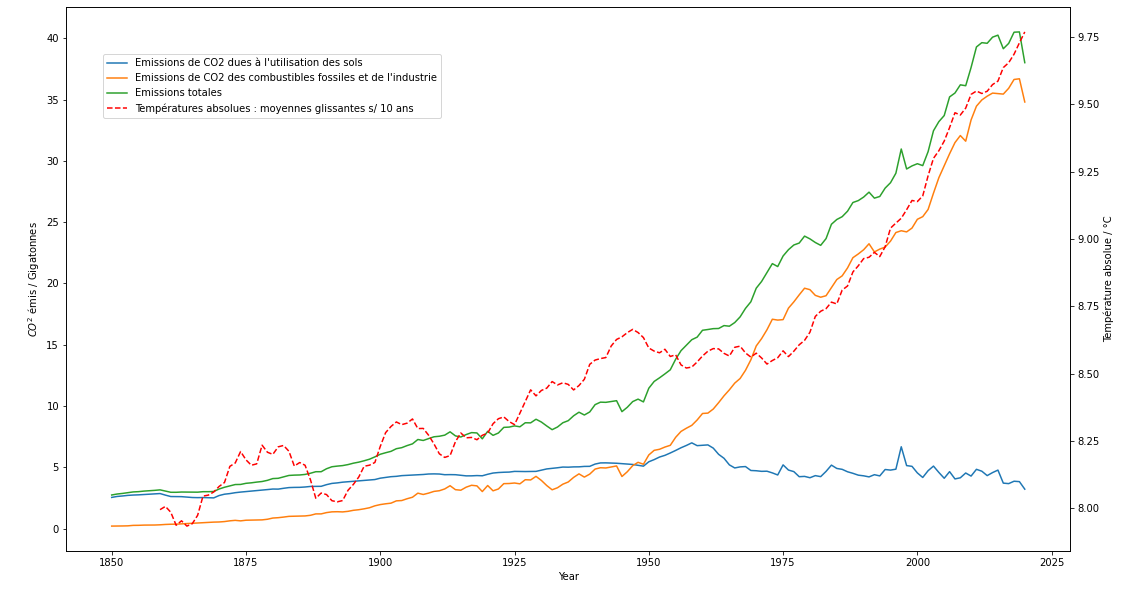

In [20]:
# Graphique évol temp / moyenne glissante 10 ans + CO2

#plt.figure(figsize=(20,12))

fig, ax1 = plt.subplots(figsize=(18,10))

ax1.plot(co2_temps['year'], co2_temps['Land use emissions (GtCO2)'],
         label = "Emissions de CO2 dues à l'utilisation des sols")
ax1.plot(co2_temps['year'], co2_temps['Fossil fuel and industry emissions (GtCO2)'],
         label = "Emissions de CO2 des combustibles fossiles et de l'industrie")
ax1.plot(co2_temps['year'], co2_temps['Total emissions (GtCO2)'],
         label="Emissions totales")
ax1.set_xlabel("Year")
ax1.set_ylabel("$CO^2$ émis / Gigatonnes")

ax2 = ax1.twinx()
ax2.plot(co2_temps['year'], co2_temps['abs_10y_mov_avg'], c='r', linestyle='--',
         label = "Températures absolues : moyennes glissantes s/ 10 ans")
ax2.set_ylabel("Température absolue / °C")

fig.legend(loc='upper center', bbox_to_anchor=(0.21, 0.75))
fig.show();

Visuellement, la hausse des températures semble suivre la hausse des émissions totales de CO2, bien que de manière moins linéaire.
Nous constatons également une nette baisse des émissions de CO2 en 2020, liée à la baisse globale d'activité pendant la crise Covid.

Grâce au test de Pearson (adapté aux variables continues), déterminons statistiquement les degrés de corrélation.
Une HeatMap nous permet de les repérer visuellement :

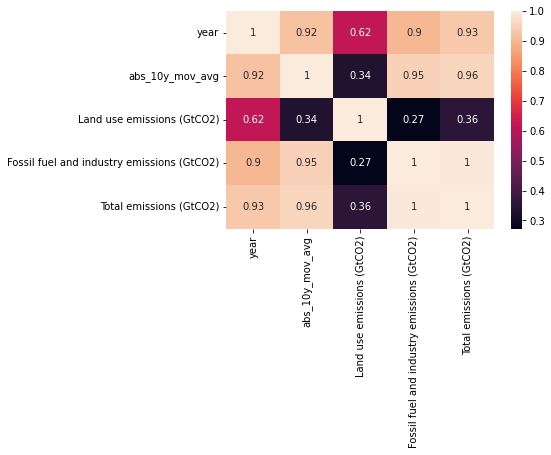

In [21]:
import seaborn as sns

sns.heatmap(co2_temps.drop('abs', axis=1).corr(method="pearson"), annot=True);

Vérifions maintenant la p-value pour les coefficients de corrélation des paires de variables qui nous intéressent :

In [22]:
from scipy.stats import pearsonr

pearson_test_dict = {}
pearson_test_dict["Températures / Années"] = pearsonr(co2_temps['abs_10y_mov_avg'].loc[co2_temps['year']>=1860],
                                                     co2_temps['year'].loc[co2_temps['year']>=1860])
pearson_test_dict["Total émissions CO2 / Années"] = pearsonr(co2_temps['Total emissions (GtCO2)'],
                                                     co2_temps['year'])
pearson_test_dict["Températures / Total émissions CO2"] = pearsonr(co2_temps['abs_10y_mov_avg'].loc[co2_temps['year']>=1860],
                                                     co2_temps['Total emissions (GtCO2)'].loc[co2_temps['year']>=1860])
pearson_test_dict["Emissions CO2 par utilisation sols / Années"] = pearsonr(co2_temps['Land use emissions (GtCO2)'],
                                                     co2_temps['year'])

df_pearson = pd.DataFrame(data=pearson_test_dict).T
df_pearson.columns = ["Coeff test Pearson", "P-value"]

df_pearson


,Coeff test Pearson,P-value
Températures / Années,0.920264,1.108349e-66
Total émissions CO2 / Années,0.933693,2.742281e-77
Températures / Total émissions CO2,0.958577,1.256212e-88
Emissions CO2 par utilisation sols / Années,0.618689,1.924302e-19


Les p-values pour chaque test sont toutes très proches de 0. Nous rejetons donc l'hypothèse nulle $H_0$ selon laquelle les variables de chaque paire sont indépendantes entre elles. 
Ainsi, nous pouvons confirmer que :

- Les émissions totales de $CO^2$ et les températures moyennes sur 10 ans ont chacune une forte corrélation aux années : coefs > 0.9.

  Les années passant, les émissions de $CO^2$ et les températures augmentent.

- Les températures moyennes sur 10 ans et les émissions totales le sont encore plus entre elles : coef > 0.95.

  Au-delà de la tendance générale à la hausse de ces 2 variables, cela confirme que les variations de l'une suit les variations de l'autre.

- Les émissions dues à l'utilisation des sols ne sont que moyennement corrélées aux années : coef = 0.62. 

  Sur le graphique, nous observions en effet une baisse de celles-ci sur le dernier tiers de la période étudiée (1960 - 2020). 

- La corrélation entre les émissions totales de $CO^2$ et les émissions des combustibles fossiles et de l'industrie est quasi parfaite. Ces dernières sont donc en majeure partie responsable de la totalité des émissions.

Intéressons nous de plus près à la relation qu'entretiennent émissions de $CO^2$ et températures. Nous pouvons la visualiser à l'aide d'un scatterplot :

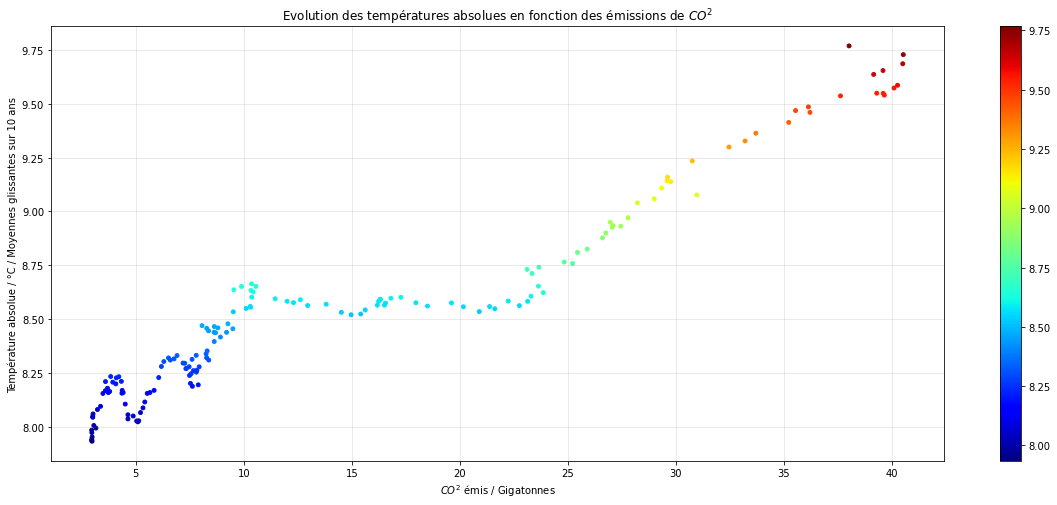

In [23]:
plt.figure(figsize=(20,8))
plt.grid(color='grey', alpha=0.2)

plt.scatter(co2_temps['Total emissions (GtCO2)'], co2_temps['abs_10y_mov_avg'], 
            c=co2_temps['abs_10y_mov_avg'], cmap='jet', s=15)

plt.xlabel('$CO^2$ émis / Gigatonnes')
plt.ylabel('Température absolue / °C / Moyennes glissantes sur 10 ans')
plt.title("Evolution des températures absolues en fonction des émissions de $CO^2$")
plt.colorbar()
plt.show()

Nous avons vu grâce aux tests statistiques que ces 2 variables sont fortement corrélées, il n'est pas surprenant d'observer une relative linéarité dans cette représentation graphique.

Modélisons ce lien avec une régression linéaire simple :

In [24]:
from sklearn.linear_model import LinearRegression

temp_lr = co2_temps['abs_10y_mov_avg'].loc[9:]
co2_lr = co2_temps[['Total emissions (GtCO2)']].loc[9:]

slr = LinearRegression()
slr.fit(co2_lr, temp_lr)

LinearRegression()

In [25]:
print(slr.intercept_)
print(slr.coef_)

7.98864401361582
[0.03814822]


On peut interprêter le modèle de cette façon :

$Température \ (°C) = 7.989 + 0.0381 \ \times émissions \ de \ CO2 \ (Gt)$.

Evaluation du modèle :

In [26]:
from sklearn.metrics import r2_score

pred_temp_lr = slr.predict(co2_lr)
r2_score(temp_lr, pred_temp_lr)

0.9192523982313386

Notre modèle obtient un score R2 proche de 0.92, il est donc performant et confirme la linéarité entre nos variables. Les émissions de $CO^2$ constituent donc bien un facteur majeur de la hausse des températures.

Forts des résultats des tests statistiques de Pearson, et du score obtenu par le modèle de régression linéaire, nous sommes à présent en mesure d'affirmer que **statistiquement, la hausse des températures est très fortement liée à celle des émissions de $CO^2$**.

**Attention cependant** : dans le cadre d'une étude statistique comme la nôtre, **corrélation ou linéarité ne signifient pas nécessairement causalité**.

## Modélisation / prédiction de la température sur les prochaines années.





Parmi les différents modèles, nous avons choisi Facebook Prophet.

Prophet permet la prédiction des données de séries temporelles, en se basant sur un modèle additif : aux tendances non-linéaires s'ajoute une composante liée à la saisonnalité. Cette librairie est donc particulièremet adaptée à notre étude.

In [27]:
#Installation du package:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importation des dépendances nécessaires pour le Prophete:

In [28]:
import datetime as datetime
from prophet import Prophet

Nous allons filtrer quelques colonnes de notre data set "global_land". NeuralProphet ne s’attend qu’à deux colonnes (temporalité / donnée).
De plus, concentrons nous sur la période où la tendance croissante de la température est constante et forte, c'est à dire à partir de 1975:

In [29]:
new_column = global_land.loc[(global_land['date'] >= '1975-01-15')] 
new_column = new_column[['date', 'abs']] 
new_column.dropna(inplace=True)
new_column.columns = ['ds', 'y'] 
new_column.tail()

,ds,y
3260,2021-09-15,13.340
3261,2021-10-15,10.804
3262,2021-11-15,7.413
3263,2021-12-15,4.981
3264,2022-01-15,4.005


Nous visualisons bien que pendant la période entre 1975 et 2022 la tendance de la température absolue est explicite, croissante, constante et forte : 

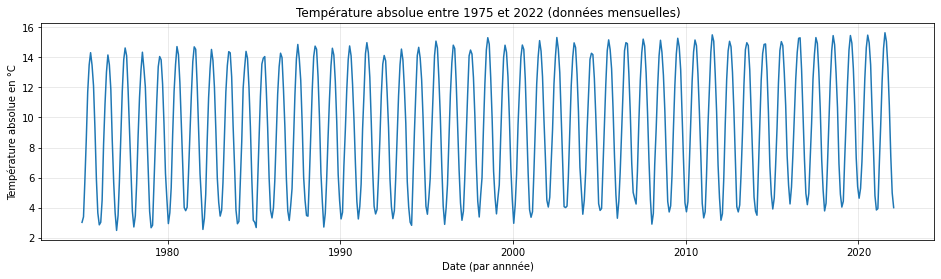

In [30]:
plt.figure(figsize=(16,4))
plt.plot(new_column['ds'], new_column['y'])
plt.xlabel('Date (par annnée)')
plt.ylabel('Température absolue en °C')
plt.title("Température absolue entre 1975 et 2022 (données mensuelles)")
plt.grid(color='grey', alpha=0.2)
plt.show()

Entraînement du modèle de prévision :

In [31]:
m = Prophet(seasonality_mode='additive').fit(new_column)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_piod6go/39m9tu09.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_piod6go/ddoufjh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24913', 'data', 'file=/tmp/tmp_piod6go/39m9tu09.json', 'init=/tmp/tmp_piod6go/ddoufjh7.json', 'output', 'file=/tmp/tmpmgrmo_78/prophet_model-20220827100431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:04:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:04:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prédiction de la température sur les 50 prochaines années :

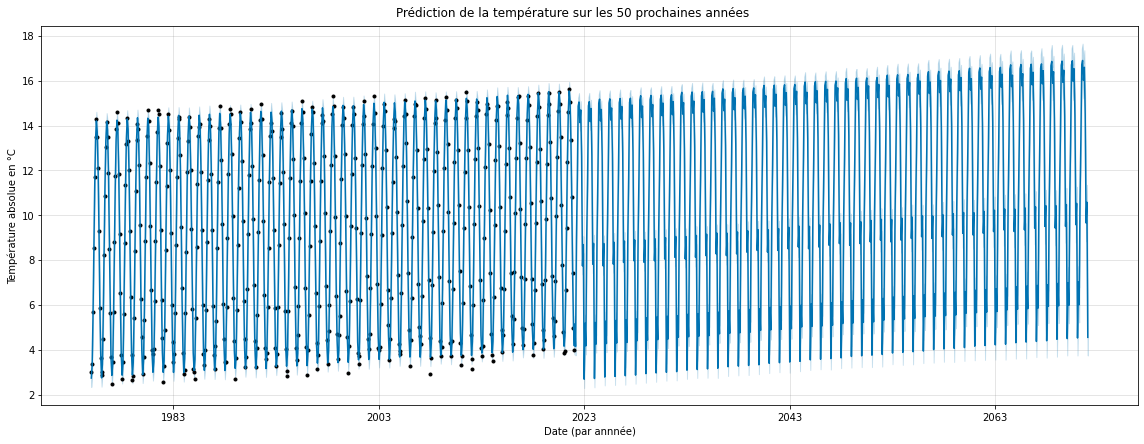

In [32]:
future = m.make_future_dataframe(periods=600, freq='M')
fcst = m.predict(future)

fig = m.plot(fcst, figsize=(16,6), xlabel ='Date (par annnée)', ylabel='Température absolue en °C')
fig.suptitle("Prédiction de la température sur les 50 prochaines années",  y=1.02)
import warnings
warnings.filterwarnings("ignore")

L'outil `plot_components` nous permet de visualiser les 2 composantes de la prédiction :
- la tendance ;
- les déviations saisonnières de cette tendance :

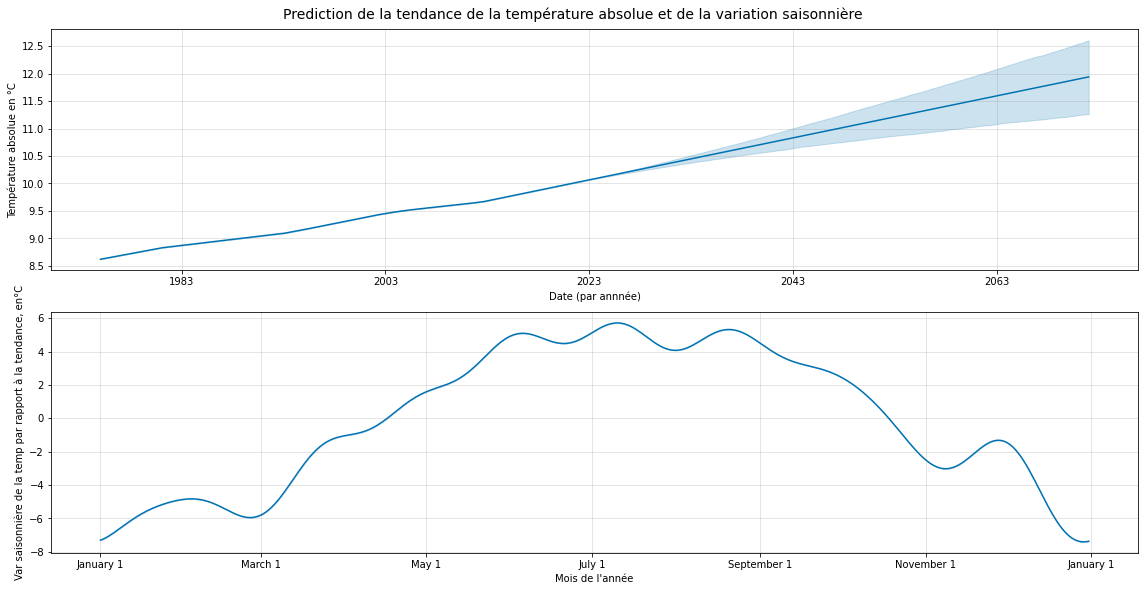

In [33]:
fig = m.plot_components(fcst, figsize=(16,8))
fig.suptitle("Prediction de la tendance de la température absolue et de la variation saisonnière", y=1.02, fontsize=14)
axes = fig.get_axes()
axes[0].set_xlabel('Date (par annnée)')
axes[0].set_ylabel('Température absolue en °C')
axes[1].set_xlabel("Mois de l'année")
axes[1].set_ylabel('Var saisonnière de la temp par rapport à la tendance, en°C')
warnings.filterwarnings("ignore")

Notre prévision est basée sur le principe que la température globale absolue va suivre la même tendance que ces derniers 46 ans, sans action climatique majeure. Dans ce cas, notre modèle prédit une croissance approximative de 1.9 °Celsius dans 50 ans. 
En comparaison avec la multitude d'études prévisionnelles qui existent actuellement, notre résultat semble juste et raisonnable, mais pas du tout positif ni pour notre planète Terre (UnhapPy Earth), ni pour l'humanité.

# Conclusion 


Grâce à l'analyse statistique de données fiables et concrètes, nous avons pu répondre aux problématiques posées en début de projet
- Nous avons pu confirmer et quantifier le réchauffement climatique : c'est une réalité indiscutable.
- Le phénomène est graduel depuis la révolution industrielle de 1880, et s'accélère à partir de 1975, de manière plus forte encore dans l'hémisphère nord.
- Les émissions de $CO^2$ ont une forte influence (corrélation / linéarité) sur la hausse des températures.
- Nos prédictions ne sont pas optimistes. D'après notre modèle Prophet, la température moyenne globale augmentera de près de 2°C dans les 50 prochaines années.

Ces résultats rejoignent ceux de la majorité des études disponibles sur le changement climatique :
- https://www.ecologie.gouv.fr/hausse-temperature-globale-sest-encore-accentuee-selon-dernier-rapport-du-giec
- https://www.francelive.fr/article/france-live/vous-pouvez-desormais-savoir-le-changement-climatique-que-vous-subirez-selon-votre-age-7403908/
- https://www.lefigaro.fr/sciences/rechauffement-climatique-les-previsions-alarmantes-de-meteo-france-20210201

Afin de compléter notre étude, de nombreux autres facteurs impactants pourraient être analysés, notamment :
- Emissions de Gaz à Effet de Serre autre que le $CO^2$ (méthane, etc.).
- Evolution de la répartition entre sols naturels et sols exploités par et pour l'activité humaine.

Malheureusement, nos conclusions, et a fortiori celles des experts en climatologie, ne sont positives ni pour notre planète Terre (UnhapPy Earth), ni pour l'humanité.

In [39]:
%%shell
jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Itération_1_-_Modélisation.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Itération_1_-_Modélisation.ipynb to html
[NbConvertApp] Writing 2699082 bytes to /content/drive/MyDrive/Colab Notebooks/Itération_1_-_Modélisation.html
